In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [4]:
df = pd.read_csv('C:\\Users\\WELcOME\\Downloads\\task 6\\complaints.csv')
df.shape

C:\Users\WELcOME\AppData\Local\Temp\ipykernel_7404\1587444076.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\WELcOME\\Downloads\\task 6\\complaints.csv')


(4082544, 18)

In [ ]:
#Explanatory Data Analysis (EDA) and Feature Engineering

In [5]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-08-25,2023-08-25
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Incorrect information on your report,Improper use of your report
Sub-issue,Personal information incorrect,Credit inquiries on your report that you don't...
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC."
State,TX,NY
ZIP code,77028,12110


In [6]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1479489, 2)

In [7]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [8]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting or other personal consumer reports'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Checking or savings account'],
       ['Credit card'],
       ['Debt collection'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Mortgage'],
       ['Vehicle loan or lease'],
       ['Money transfer, virtual currency, or money service'],
       ['Debt or credit management'],
       ['Prepaid card'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit reporting'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Payday loan'],
       ['Virtual currency']], dtype=object)

In [9]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [10]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [11]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Credit card or prepaid card
3,Debt collection
4,"Payday loan, title loan, or personal loan"
5,Student loan
6,Consumer Loan
7,"Money transfer, virtual currency, or money ser..."
8,Checking or savings account
9,Vehicle loan or lease


In [12]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

In [13]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [14]:
# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
109757,"Credit reporting, repair, or other",Right now I am bothered! I have attempted to b...,0
2078352,"Credit reporting, repair, or other",They automatically enrolled me in a monthly su...,0
1107843,"Credit reporting, repair, or other",I had disputed a civil public record showing o...,0
3998207,Mortgage,ILLEGAL CONVERSION WITHOUT MY CONSENT! \nMy si...,1
3050808,"Credit reporting, repair, or other",This guy is leaving a message ( XXXX XXXX ) to...,0


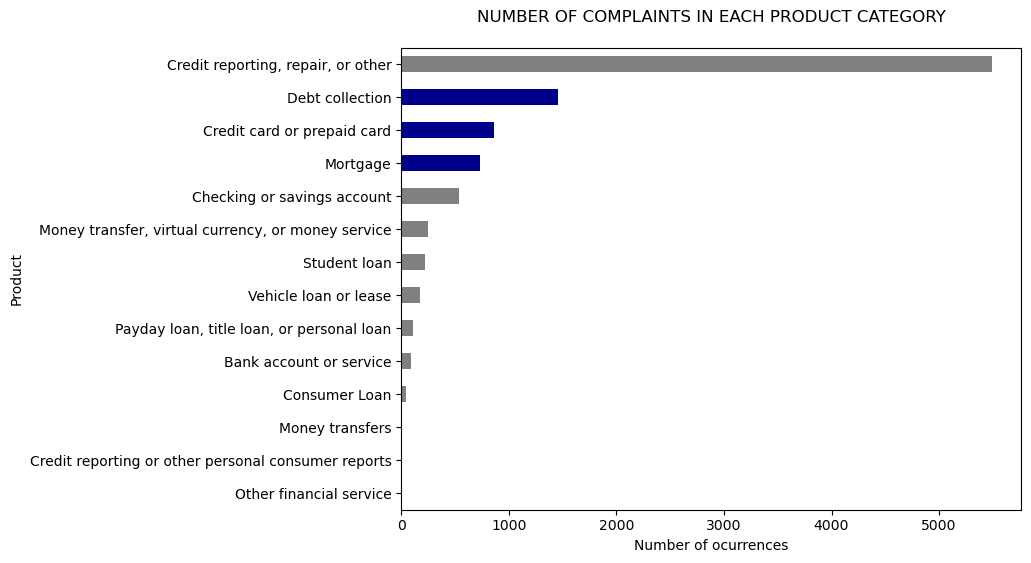

In [15]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 25820 features (TF-IDF score of unigrams and bigrams)


In [18]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: bag, bank, overdraft
  * Most Correlated Bigrams are: balance charge, direct express, charged 35


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: overdraft, savings, bank
  * Most Correlated Bigrams are: wells fargo, savings account, checking account


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: dealer, repo, ford
  * Most Correlated Bigrams are: xxxx gm, dealer services, fargo dealer


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: amex, capital, card
  * Most Correlated Bigrams are: american express, new card, credit card


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: bias, network, defamatory
  * Most Correlated Bigrams are: stole information, theft sent, im aware


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, section, reporting
  * Most Correlated Bigrams are: 15 1681, credit report, 1681 section


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: trying collect, debt collection, collect debt


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: venmo, coinbase, paypal
  * Most Correlated Bigrams are: wire transfer, paypal account, cash app


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: sound, fruad, moneygram
  * Most Correlated Bigrams are: money said, send money, xxxx text


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: escrow account, mortgage company, loan modification


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: cashing, project, western
  * Most Correlated Bigrams are: suspected fraud, agent called, western union


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: debiting, payday, affirm
  * Most Correlated Bigrams are: payday loan, got loan, loan charged


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: forgiveness, student, navient
  * Most Correlated Bigrams are: sallie mae, loan forgiveness, student loan

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: vehicle, gap, car
  * Most Correlated Bigrams are: toyota financial, honda financial, gap insurance


C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
#Selection of Multi Classification model

In [21]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = se

In [ ]:
#Comparison of model performance

In [22]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.82580,0.010390
LogisticRegression,0.80550,0.009414
MultinomialNB,0.68460,0.007901
RandomForestClassifier,0.54875,0.000354


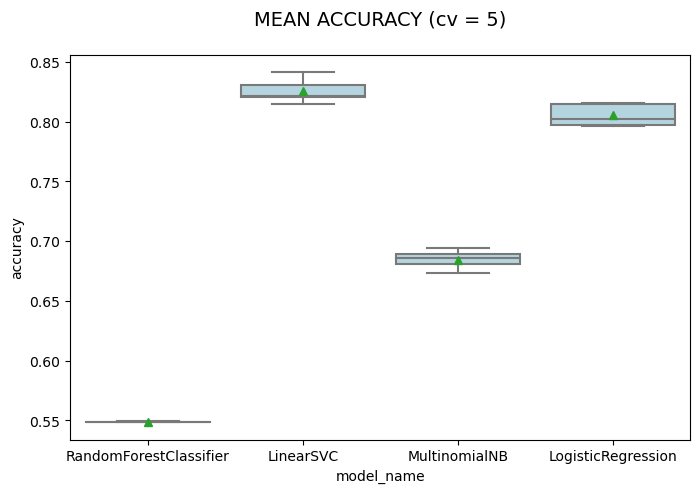

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
#Model Evaluation

In [24]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                     precision    recall  f1-score   support

                 Credit reporting, repair, or other       0.88      0.94      0.91      1384
                                           Mortgage       0.86      0.85      0.86       186
                        Credit card or prepaid card       0.74      0.75      0.74       213
                                    Debt collection       0.71      0.70      0.70       361
          Payday loan, title loan, or personal loan       0.80      0.11      0.20        35
                                       Student loan       0.87      0.72      0.79        54
                                      Consumer Loan       0.00      0.00      0.00        12
 Money transfer, virtual currency, or money service       0.64      0.60      0.62        50
                        Checking or savings account       0.68      0.79      0.73       133
                              Vehicle lo

C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


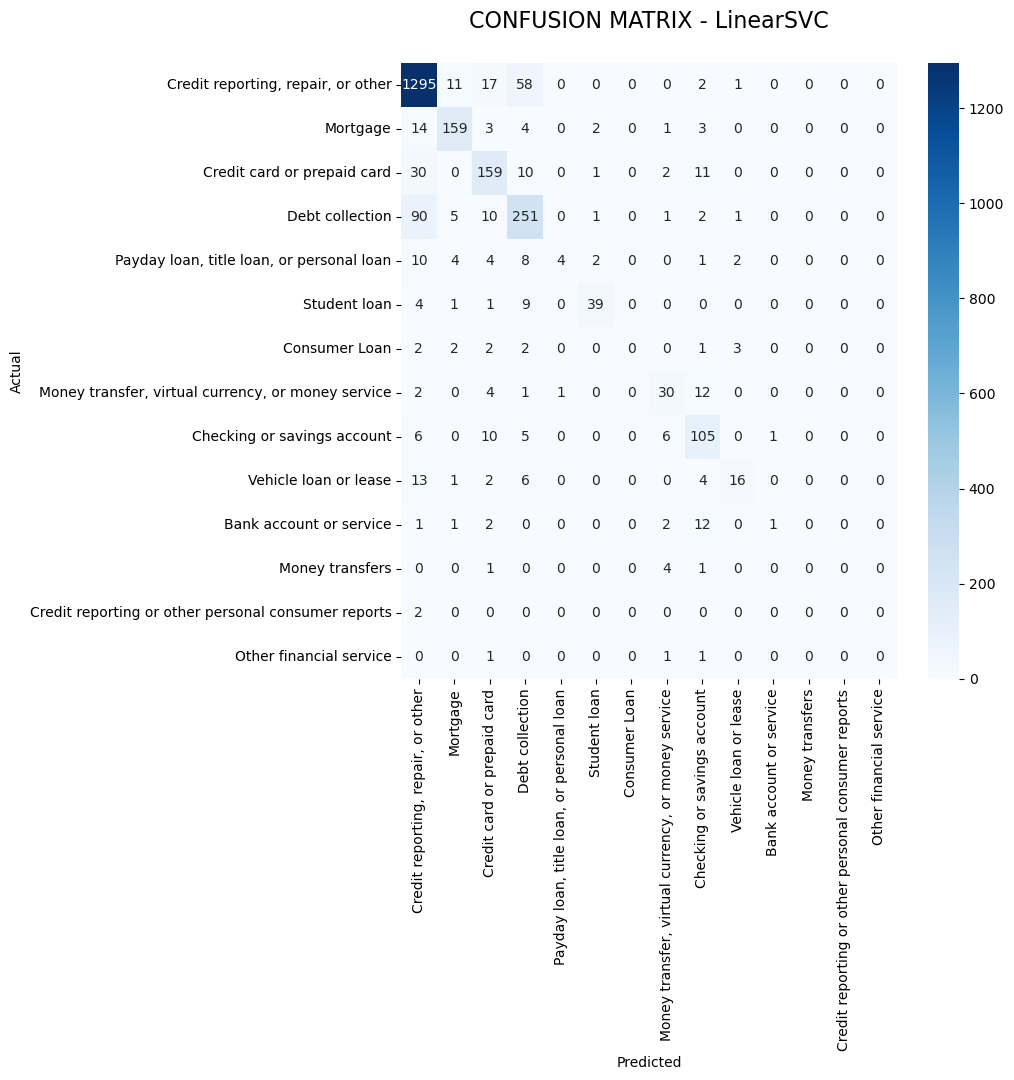

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [ ]:
#Misclassified complaints

In [27]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 30 examples.


,Product,Consumer_complaint
1684178,Credit card or prepaid card,Credit karma has pre approved me for credit ca...
2397866,Credit card or prepaid card,"On or about XX/XX/XXXX, according to my XXXX c..."
3097492,Credit card or prepaid card,Account was opened in XX/XX/XXXX. \nBank is sa...
489611,Credit card or prepaid card,XX/XX/2021 XXXX XXXX XXXX XXXX XXXX XXXXXXXX X...
2287473,Credit card or prepaid card,Ollo Card Services has not updated my account ...
1030315,Credit card or prepaid card,"Dear Sir or Madam, -1. CACAPITAL ONE XXXX Plea..."
101471,Credit card or prepaid card,The current issue is causing me significant di...
3085496,Credit card or prepaid card,Paid my account in full on the internet -wordi...
699241,Credit card or prepaid card,My credit card was stolen and used to make cha...
2008084,Credit card or prepaid card,I got a JCPENNY Credit Card. The store employe...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 90 examples.


,Product,Consumer_complaint
324621,Debt collection,On the month of XX/XX/2020 I CONTACTED XXXX XX...
2800749,Debt collection,I wish to file this complaint against Portfoli...
203383,Debt collection,I have gone through my annual check at my XXXX...
3402823,Debt collection,I have contacted Equifax numerous times regard...
236605,Debt collection,Choice Recovery Inc. Balance owed is {$3100.00...
...,...,...
3850877,Debt collection,I declare under penalty of perjury ( under the...
910411,Debt collection,DiscoverCard had their lawyer send me a letter...
438061,Debt collection,More detailed information may be round in a pr...
3357744,Debt collection,I have items on my consumer credit report I do...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 58 examples.


,Product,Consumer_complaint
3595281,"Credit reporting, repair, or other",Capital One is in violation of numerous consum...
1149979,"Credit reporting, repair, or other",They can not produce a credit appl or a repaym...
398186,"Credit reporting, repair, or other","XXXX, XXXX XXXX SOC SEC # XXXX DOB XX/XX/XXXX ..."
481676,"Credit reporting, repair, or other",Hello so we had a used car business in XXXX op...
729274,"Credit reporting, repair, or other","The address on the account, was incorrect."
3699762,"Credit reporting, repair, or other",A judgement is on my credit report for XXXX ca...
3654628,"Credit reporting, repair, or other",A pay to delete letter with sent into the comp...
2198006,"Credit reporting, repair, or other",I asked the original creditor for verification...
1600124,"Credit reporting, repair, or other",I had an account with XXXX and I was paying re...
1656623,"Credit reporting, repair, or other","Back in XXXX, around XX/XX/, I got a notificat..."


In [28]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

C:\Users\WELcOME\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> 'Bank account or service':
  * Top unigrams: bank, 2016, direct, overdraft
  * Top bigrams: charged 35, balance charge, direct express, receive check

==> 'Checking or savings account':
  * Top unigrams: bank, savings, branch, chime
  * Top bigrams: savings account, wells fargo, debit card, taken account

==> 'Consumer Loan':
  * Top unigrams: car, finance, repo, primary
  * Top bigrams: fargo dealer, dealer services, fax number, xxxx set

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, amex, synchrony
  * Top bigrams: balance transfer, credit card, new card, american express

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: network, aware, defamatory, bias
  * Top bigrams: im aware, address listed, theft sent, stole information

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, equifax, report, transunion
  * Top bigrams: xxxx xxxx, xxxx balance, different collection, xxxx transunion

==> 'Debt collection':
  * T

In [ ]:
#Prediction

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [32]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [33]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id


In [34]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [35]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
